# FIFA 2018 World Cup Dataset 
## Objective - To Predict the Man of the Match


## 1. Import required packages and data

In [1]:
import os
import colorlover as cl
import pandas as pd
import numpy as np
import seaborn as sns

import lightgbm as lgbm
import plotly.offline as py
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.model_selection import GridSearchCV as gs
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.externals import joblib

import warnings
py.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas_profiling

/Users/pratikajitb/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/pratikajitb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install j

In [2]:
#Importing Data

fifa_data = pd.read_csv("https://github.com/insaid2018/Term-2/raw/master/Projects/FIFA%202018%20Statistics.csv")
fifa_data = fifa_data.loc[:, ~fifa_data.columns.str.contains('^Unnamed')]
fifa_data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


## How big is it? (Data Size)

In [3]:
fifa_data.shape

(128, 27)

It shows us that the whole data frame has 128 rows and 27 columns in total.

## Data Types
<p>
Data has a variety of types.</b>The main types stored in Pandas dataframes are <b>object</b>, <b>float</b>, <b>int</b>, <b>bool</b> and <b>datetime64</b>. In order to better learn about each attribute, it is always good to know the data type of each column. In Pandas:
</p>

In [4]:
fifa_data.dtypes

Date                       object
Team                       object
Opponent                   object
Goal Scored                 int64
Ball Possession %           int64
Attempts                    int64
On-Target                   int64
Off-Target                  int64
Blocked                     int64
Corners                     int64
Offsides                    int64
Free Kicks                  int64
Saves                       int64
Pass Accuracy %             int64
Passes                      int64
Distance Covered (Kms)      int64
Fouls Committed             int64
Yellow Card                 int64
Yellow & Red                int64
Red                         int64
Man of the Match           object
1st Goal                  float64
Round                      object
PSO                        object
Goals in PSO                int64
Own goals                 float64
Own goal Time             float64
dtype: object

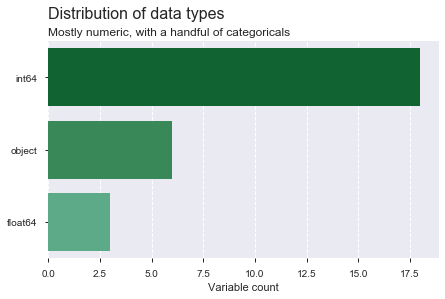

In [5]:
dtype_counts = fifa_data.dtypes.value_counts()

fig, ax = plt.subplots(1, 1, figsize=[7, 4])
sns.barplot(y=dtype_counts.index.astype(str), x=dtype_counts, ax=ax, 
            palette=sns.color_palette("BuGn_r"))

for side in ['top', 'right', 'left']:
    ax.spines[side].set_visible(False)
ax.grid(axis='x', linestyle='--')
ax.set_xlabel('Variable count')

plt.suptitle('Distribution of data types', ha='left', fontsize=16, x=.125, y=1)
plt.title('Mostly numeric, with a handful of categoricals', ha='left', x=0)
plt.show()

## Data Profiling

In [6]:
fifa_data.describe(include="all")

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
count,128,128,128,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128,94.000000,128,128,128.000000,12.0,12.000000
unique,25,32,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,NaN,6,2,NaN,NaN,NaN
top,17-06-2018,Belgium,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Yes,NaN,Group Stage,No,NaN,NaN,NaN
freq,8,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,64,NaN,96,120,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.320312,49.992188,12.593750,3.914062,5.273438,3.359375,4.718750,...,1.695312,0.015625,0.015625,NaN,39.457447,NaN,NaN,0.203125,1.0,45.833333
std,NaN,NaN,NaN,1.156519,10.444074,5.245827,2.234403,2.409675,2.403195,2.446072,...,1.325454,0.124507,0.124507,NaN,24.496506,NaN,NaN,0.807049,0.0,29.978275
min,NaN,NaN,NaN,0.000000,25.000000,3.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,NaN,1.000000,NaN,NaN,0.000000,1.0,12.000000
25%,NaN,NaN,NaN,0.000000,42.000000,9.000000,2.000000,4.000000,1.750000,3.000000,...,1.000000,0.000000,0.000000,NaN,18.250000,NaN,NaN,0.000000,1.0,21.750000
50%,NaN,NaN,NaN,1.000000,50.000000,12.000000,3.500000,5.000000,3.000000,5.000000,...,2.000000,0.000000,0.000000,NaN,39.000000,NaN,NaN,0.000000,1.0,35.000000
75%,NaN,NaN,NaN,2.000000,58.000000,15.000000,5.000000,7.000000,4.000000,6.000000,...,2.000000,0.000000,0.000000,NaN,54.750000,NaN,NaN,0.000000,1.0,75.750000


Now, it provides the statistical summary of all the columns, including object-typed attributes.
We can now see how many unique values, which is the top value and the frequency of top value in the object-typed columns.
Some values in the table above show as "NaN", this is because those numbers are not available regarding a particular column type.

## How's it looking for nulls?

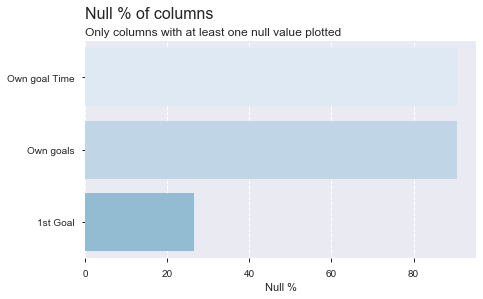

In [7]:
null_sums = fifa_data.isnull().sum()
null_sums = null_sums[null_sums > 0].sort_values(ascending=False)

fig, ax = plt.subplots(1, 1, figsize=[7, 4])
sns.barplot(y=null_sums.index, x=100 * null_sums / len(fifa_data), 
            ax=ax, palette=sns.color_palette("Blues"))

for side in ['top', 'right', 'left']:
    ax.spines[side].set_visible(False)
ax.grid(axis='x', linestyle='--')
ax.set_xlabel('Null %')

plt.suptitle('Null % of columns', ha='left', fontsize=16, x=.125, y=1)
plt.title('Only columns with at least one null value plotted', ha='left', x=0)
plt.show()

Not bad, only three columns with any null values. For __*1st goal*__ and __*Own goal time*__, the nulls make sense as they're both measures of time when an event occured - and if that event never occured the data will be missing.

In [8]:
profile = pandas_profiling.ProfileReport(fifa_data)
profile.to_file(output_file="fifa2018_data_before_preprocessing.html")

## Pre-Profiling Summary
----
- __1st_Goal__ has 34 (26.6%) missing values
- __Own_goal_Time__ has 116 (90.6%) missing values
- __Own_goals__ has 116 (90.6%) missing values

- __Blocked__ has 6 (4.7%) zeros	
- __Corners__ has 3 (2.3%) zeros	
- __Date__ only contains datetime values, but is categorical.
- __Goal_Scored__ has 33 (25.8%) zeros	
- __Offsides__ has 33 (25.8%) zeros	
- __On-Target__ has 4 (3.1%) zeros	
- __Saves__ has 15 (11.7%) zeros	
- __Yellow_Card__ has 25 (19.5%) zeros

# 2. Re-formatting the data set

The current layout of the data, with 2 rows per match showing the data from perspective either team, makes it slightly tricky to investigate a few things directly i.e. who won! A relatively key peice of info...

Therefore I'd like to reformat it such that each row corresponds to a particular match, and the data by team is included in additional columns. To do this I need to
- __1. Join the dataset to itself by match (so on date = date and team = opposition)__
- __2. Delete resulting 'duplicated' rows that are reverses of each other following the join__

In [9]:
match_df = fifa_data.merge(fifa_data, left_on=['Date', 'Team'], right_on=['Date', 'Opponent'], 
                    how='inner', suffixes=['_Team', '_Opponent'])

keep = []
for i, row in match_df.iterrows():
    if i > 0:
        if (row['Team_Team'] == match_df.loc[i - 1, 'Opponent_Team']) & \
            (row['Date'] == match_df.loc[i - 1, 'Date']):
            continue
        else:
            keep.append(i)
            
match_df = match_df.loc[keep, :]
match_df.head()

,Date,Team_Team,Opponent_Team,Goal_Scored_Team,Ball_Possession_%_Team,Attempts_Team,On-Target_Team,Off-Target_Team,Blocked_Team,Corners_Team,...,Yellow_Card_Opponent,Yellow_&_Red_Opponent,Red_Opponent,Man_of_the_Match_Opponent,1st_Goal_Opponent,Round_Opponent,PSO_Opponent,Goals_in_PSO_Opponent,Own_goals_Opponent,Own_goal_Time_Opponent
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,3,0,0,Yes,90.0,Group Stage,No,0,NaN,NaN
6,15-06-2018,Portugal,Spain,3,39,8,3,2,3,4,...,1,0,0,Yes,24.0,Group Stage,No,0,NaN,NaN
8,16-06-2018,France,Australia,2,51,12,5,4,3,5,...,3,0,0,No,62.0,Group Stage,No,0,1.0,81.0
10,16-06-2018,Argentina,Iceland,1,72,26,7,9,10,10,...,0,0,0,Yes,23.0,Group Stage,No,0,NaN,NaN


## Following the reformat, I can now add a column describing the outcome of the match.

In [10]:
match_df.loc[match_df['Goal_Scored_Team'] > match_df['Goal_Scored_Opponent'], 'Result'] = 'Team win'
match_df.loc[match_df['Goal_Scored_Team'] < match_df['Goal_Scored_Opponent'], 'Result'] = 'Opponent win'
match_df.loc[match_df['Goal_Scored_Team'] == match_df['Goal_Scored_Opponent'], 'Result'] = 'Draw'
match_df.loc[(match_df['Goal_Scored_Team'] == match_df['Goal_Scored_Opponent']) &
             (match_df['Goals_in_PSO_Team'] < match_df['Goals_in_PSO_Opponent']), 'Result'] = 'Opponent win (Pens)'
match_df.loc[(match_df['Goal_Scored_Team'] == match_df['Goal_Scored_Opponent']) &
             (match_df['Goals_in_PSO_Team'] > match_df['Goals_in_PSO_Opponent']), 'Result'] = 'Team win (Pens)'

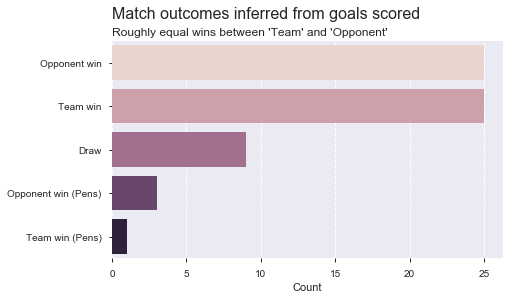

In [11]:
results_count = match_df['Result'].value_counts()

fig, ax = plt.subplots(1, 1, figsize=[7, 4])
sns.barplot(y=results_count.index, x=results_count, ax=ax, 
            palette=sns.cubehelix_palette(5))

for side in ['top', 'right', 'left']:
    ax.spines[side].set_visible(False)
ax.grid(axis='x', linestyle='--')
ax.set_xlabel('Count')

plt.suptitle('Match outcomes inferred from goals scored', ha='left', fontsize=16, x=.125, y=1)
plt.title('Roughly equal wins between \'Team\' and \'Opponent\'', ha='left', x=0)
plt.show()

# 3. How to win a World Cup match?

## Work real hard? (Distance Covered)
Intuitively it seems as if the more your team can run the better chance they'll have; but in football it's often a hallmark of less technically skilled teams. It's not easy to predict therefore how it'll influence a world cup match.

Fortunately, we have some data:

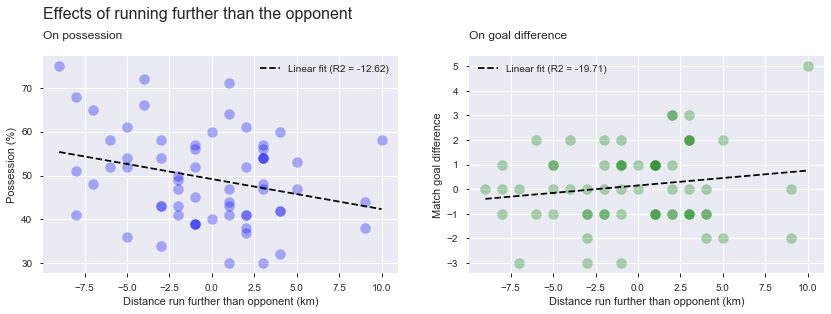

In [13]:
match_df['Distance_vs_Opponent'] = match_df['Distance_Covered_(Kms)_Team'] - match_df['Distance_Covered_(Kms)_Opponent']
match_df['Goal_Difference'] = match_df['Goal_Scored_Team'] - match_df['Goal_Scored_Opponent']


lm1 = LinearRegression().fit(match_df['Distance_vs_Opponent'].values.reshape(-1, 1), match_df['Ball_Possession_%_Team'])
extremes = np.array([match_df['Distance_vs_Opponent'].min(), match_df['Distance_vs_Opponent'].max()]).reshape(-1, 1)
poss_pred = lm1.predict(match_df['Ball_Possession_%_Team'].values.reshape(-1, 1))
poss_pred_plot = lm1.predict(extremes)

lm2 = LinearRegression().fit(match_df['Distance_vs_Opponent'].values.reshape(-1, 1), match_df['Goal_Difference'])
gd_pred = lm2.predict(match_df['Ball_Possession_%_Team'].values.reshape(-1, 1))
gd_pred_plot = lm2.predict(extremes)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 4])

ax.scatter(match_df['Distance_vs_Opponent'], match_df['Ball_Possession_%_Team'], edgecolors='blue', alpha=.3,
           s=100, c='blue')
ax.plot(extremes, poss_pred_plot, color='k', linestyle='--', 
        label='Linear fit (R2 = {:.2f})'.format(r2_score(match_df['Ball_Possession_%_Team'], poss_pred)))
ax.set_ylabel('Possession (%)')
ax.set_title('On possession', ha='left', fontsize=12, x=0, y=1.05)

ax1.scatter(match_df['Distance_vs_Opponent'], match_df['Goal_Difference'], edgecolors='green', alpha=.3,
           s=100, c='green')
ax1.plot(extremes, gd_pred_plot, color='k', linestyle='--', 
        label='Linear fit (R2 = {:.2f})'.format(r2_score(match_df['Ball_Possession_%_Team'], gd_pred)))
ax1.set_ylabel('Match goal difference')
ax1.set_title('On goal difference', ha='left', fontsize=12, x=0, y=1.05)

for a in (ax, ax1):
    a.legend(frameon=False)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.set_xlabel('Distance run further than opponent (km)')

plt.suptitle('Effects of running further than the opponent', ha='left', x=.125, fontsize=16, y=1.05)
plt.show()

So running more suggests that possession will be lower - which makes sense since teams generally have to do more running out of possession to get in defensive position, cover possible passes and gegenpress.

What it means for goal difference in the match is less clear. Visually there seems to be a positive correlation but the r2 score isn't great.

---
Lets cut to the chase and directly compare it to the result - as well as seeing who that hardest working teams are.

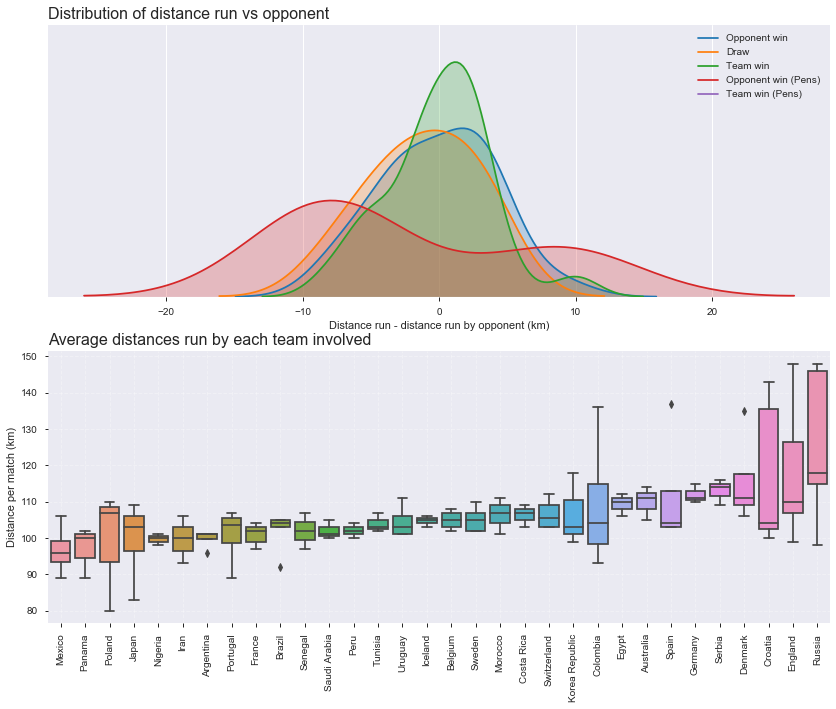

In [14]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=[14, 11])

for res in match_df['Result'].unique():
    sns.kdeplot(match_df.loc[match_df['Result'] == res, 'Distance_vs_Opponent'], 
                ax=ax, label=res, shade=True)

ax.set_title('Distribution of distance run vs opponent', ha='left', fontsize=16, x=0, y=1)
ax.set_xlabel('Distance run - distance run by opponent (km)')    

for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.yaxis.set_visible(False)
ax.set_ylim([ax.get_ylim()[0], 0.13])
ax.legend(frameon=False)

order = fifa_data.groupby('Team')['Distance_Covered_(Kms)'].mean().sort_values().index

sns.boxplot(x='Team', y='Distance_Covered_(Kms)', data=fifa_data, order=order)

ax1.set_title('Average distances run by each team involved', ha='left', fontsize=16, x=0, y=1)
ax1.set_xlabel('')
ax1.set_ylabel('Distance per match (km)')

for spine in ['top', 'left', 'right', 'bottom']:
    ax1.spines[spine].set_visible(False)

ax1.grid(linestyle='--', alpha=.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

plt.autoscale()
plt.show()

So despite the correlations seen previously, there isn't a strong indication that distance run will greatly improve the chances of winning.

The eventual winners, France, are towards the lower end of distance run - whilst two of the semi finalists, England and Croatia, were some of the hardest runners.

## Keep the ball ? (Ball Possession)
Another idea, stemming from the paint-drying days of Iberian tiki-taka, is that the more possession means more winning.

They can't score if they haven't got the ball, right?

No handles with labels found to put in legend.


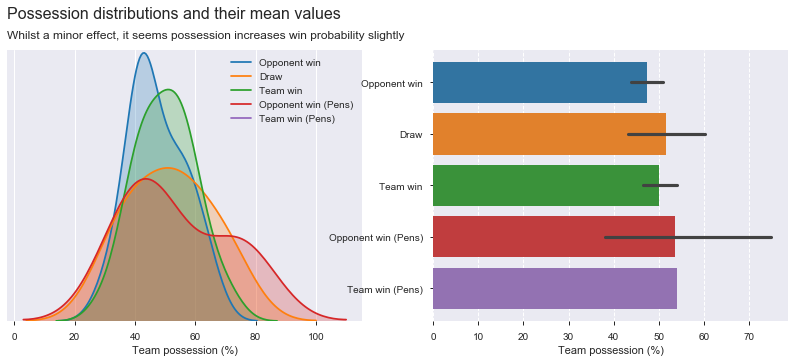

In [15]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])

for res in match_df['Result'].unique():
    sns.kdeplot(match_df.loc[match_df['Result'] == res, 'Ball_Possession_%_Team'], 
                ax=ax, label=res, shade=True)
    
ax.set_title('Whilst a minor effect, it seems possession increases win probability slightly', 
             ha='left', fontsize=12, x=0, y=1.02)
#ax.set_xlabel('Ball Possession %')    
ax.yaxis.set_visible(False)
ax.set_ylim([ax.get_ylim()[0], .04])
ax.legend(frameon=False)

sns.barplot(y='Result', x='Ball_Possession_%_Team', data=match_df, ax=ax1)
ax1.grid(axis='x', linestyle='--')
ax1.set_xlabel('Ball Possession %')
ax1.set_ylabel('')

for a in [ax, ax1]:
    for spine in ['top', 'left', 'right']:
        a.spines[spine].set_visible(False)
    a.set_xlabel('Team possession (%)')
    a.legend(frameon=False)

plt.suptitle('Possession distributions and their mean values', ha='left', x=.125, fontsize=16, y=1)
plt.autoscale()
plt.show()

Doesn't seem like it. This appears to reflect the change in tactics over the last few years in football, where __hard-pressing__, __counter attacking__ football has muscled possession based games off the top.

## Be South American / European?
A variable that is harder for a team to control, for sure, but does show a pattern - one that is a correlation not a direct causation (that is a much more complex problem).

Anyway, converting match results to a typical league points scoring system (win = 3 points, draw = 1 point, loss = 0 points), and summing the points by team allows the below chloropleth to be plotted. 

It illustrates a trend common across World Cups: that the South American and European teams usually do well.

In [16]:
country_dict = {
    'Afghanistan': 'AFG',
     'Albania': 'ALB',
     'Algeria': 'DZA',
     'American Samoa': 'ASM',
     'Andorra': 'AND',
     'Angola': 'AGO',
     'Anguilla': 'AIA',
     'Antigua and Barbuda': 'ATG',
     'Argentina': 'ARG',
     'Armenia': 'ARM',
     'Aruba': 'ABW',
     'Australia': 'AUS',
     'Austria': 'AUT',
     'Azerbaijan': 'AZE',
     'Bahamas, The': 'BHM',
     'Bahrain': 'BHR',
     'Bangladesh': 'BGD',
     'Barbados': 'BRB',
     'Belarus': 'BLR',
     'Belgium': 'BEL',
     'Belize': 'BLZ',
     'Benin': 'BEN',
     'Bermuda': 'BMU',
     'Bhutan': 'BTN',
     'Bolivia': 'BOL',
     'Bosnia and Herzegovina': 'BIH',
     'Botswana': 'BWA',
     'Brazil': 'BRA',
     'British Virgin Islands': 'VGB',
     'Brunei': 'BRN',
     'Bulgaria': 'BGR',
     'Burkina Faso': 'BFA',
     'Burma': 'MMR',
     'Burundi': 'BDI',
     'Cabo Verde': 'CPV',
     'Cambodia': 'KHM',
     'Cameroon': 'CMR',
     'Canada': 'CAN',
     'Cayman Islands': 'CYM',
     'Central African Republic': 'CAF',
     'Chad': 'TCD',
     'Chile': 'CHL',
     'China': 'CHN',
     'Colombia': 'COL',
     'Comoros': 'COM',
     'Congo, Democratic Republic of the': 'COD',
     'Congo, Republic of the': 'COG',
     'Cook Islands': 'COK',
     'Costa Rica': 'CRI',
     "Cote d'Ivoire": 'CIV',
     'Croatia': 'HRV',
     'Cuba': 'CUB',
     'Curacao': 'CUW',
     'Cyprus': 'CYP',
     'Czech Republic': 'CZE',
     'Denmark': 'DNK',
     'Djibouti': 'DJI',
     'Dominica': 'DMA',
     'Dominican Republic': 'DOM',
     'Ecuador': 'ECU',
     'England': 'GBR',
     'Egypt': 'EGY',
     'El Salvador': 'SLV',
     'Equatorial Guinea': 'GNQ',
     'Eritrea': 'ERI',
     'Estonia': 'EST',
     'Ethiopia': 'ETH',
     'Falkland Islands (Islas Malvinas)': 'FLK',
     'Faroe Islands': 'FRO',
     'Fiji': 'FJI',
     'Finland': 'FIN',
     'France': 'FRA',
     'French Polynesia': 'PYF',
     'Gabon': 'GAB',
     'Gambia, The': 'GMB',
     'Georgia': 'GEO',
     'Germany': 'DEU',
     'Ghana': 'GHA',
     'Gibraltar': 'GIB',
     'Greece': 'GRC',
     'Greenland': 'GRL',
     'Grenada': 'GRD',
     'Guam': 'GUM',
     'Guatemala': 'GTM',
     'Guernsey': 'GGY',
     'Guinea': 'GIN',
     'Guinea-Bissau': 'GNB',
     'Guyana': 'GUY',
     'Haiti': 'HTI',
     'Honduras': 'HND',
     'Hong Kong': 'HKG',
     'Hungary': 'HUN',
     'Iceland': 'ISL',
     'India': 'IND',
     'Indonesia': 'IDN',
     'Iran': 'IRN',
     'Iraq': 'IRQ',
     'Ireland': 'IRL',
     'Isle of Man': 'IMN',
     'Israel': 'ISR',
     'Italy': 'ITA',
     'Jamaica': 'JAM',
     'Japan': 'JPN',
     'Jersey': 'JEY',
     'Jordan': 'JOR',
     'Kazakhstan': 'KAZ',
     'Kenya': 'KEN',
     'Kiribati': 'KIR',
     'Korea, North': 'PRK',
     'Korea, South': 'KOR',
     'Korea Republic': 'KOR',
     'Kosovo': 'KSV',
     'Kuwait': 'KWT',
     'Kyrgyzstan': 'KGZ',
     'Laos': 'LAO',
     'Latvia': 'LVA',
     'Lebanon': 'LBN',
     'Lesotho': 'LSO',
     'Liberia': 'LBR',
     'Libya': 'LBY',
     'Liechtenstein': 'LIE',
     'Lithuania': 'LTU',
     'Luxembourg': 'LUX',
     'Macau': 'MAC',
     'Macedonia': 'MKD',
     'Madagascar': 'MDG',
     'Malawi': 'MWI',
     'Malaysia': 'MYS',
     'Maldives': 'MDV',
     'Mali': 'MLI',
     'Malta': 'MLT',
     'Marshall Islands': 'MHL',
     'Mauritania': 'MRT',
     'Mauritius': 'MUS',
     'Mexico': 'MEX',
     'Micronesia, Federated States of': 'FSM',
     'Moldova': 'MDA',
     'Monaco': 'MCO',
     'Mongolia': 'MNG',
     'Montenegro': 'MNE',
     'Morocco': 'MAR',
     'Mozambique': 'MOZ',
     'Namibia': 'NAM',
     'Nepal': 'NPL',
     'Netherlands': 'NLD',
     'New Caledonia': 'NCL',
     'New Zealand': 'NZL',
     'Nicaragua': 'NIC',
     'Niger': 'NER',
     'Nigeria': 'NGA',
     'Niue': 'NIU',
     'Northern Mariana Islands': 'MNP',
     'Norway': 'NOR',
     'Oman': 'OMN',
     'Pakistan': 'PAK',
     'Palau': 'PLW',
     'Panama': 'PAN',
     'Papua New Guinea': 'PNG',
     'Paraguay': 'PRY',
     'Peru': 'PER',
     'Philippines': 'PHL',
     'Poland': 'POL',
     'Portugal': 'PRT',
     'Puerto Rico': 'PRI',
     'Qatar': 'QAT',
     'Romania': 'ROU',
     'Russia': 'RUS',
     'Rwanda': 'RWA',
     'Saint Kitts and Nevis': 'KNA',
     'Saint Lucia': 'LCA',
     'Saint Martin': 'MAF',
     'Saint Pierre and Miquelon': 'SPM',
     'Saint Vincent and the Grenadines': 'VCT',
     'Samoa': 'WSM',
     'San Marino': 'SMR',
     'Sao Tome and Principe': 'STP',
     'Saudi Arabia': 'SAU',
     'Senegal': 'SEN',
     'Serbia': 'SRB',
     'Seychelles': 'SYC',
     'Sierra Leone': 'SLE',
     'Singapore': 'SGP',
     'Sint Maarten': 'SXM',
     'Slovakia': 'SVK',
     'Slovenia': 'SVN',
     'Solomon Islands': 'SLB',
     'Somalia': 'SOM',
     'South Africa': 'ZAF',
     'South Sudan': 'SSD',
     'Spain': 'ESP',
     'Sri Lanka': 'LKA',
     'Sudan': 'SDN',
     'Suriname': 'SUR',
     'Swaziland': 'SWZ',
     'Sweden': 'SWE',
     'Switzerland': 'CHE',
     'Syria': 'SYR',
     'Taiwan': 'TWN',
     'Tajikistan': 'TJK',
     'Tanzania': 'TZA',
     'Thailand': 'THA',
     'Timor-Leste': 'TLS',
     'Togo': 'TGO',
     'Tonga': 'TON',
     'Trinidad and Tobago': 'TTO',
     'Tunisia': 'TUN',
     'Turkey': 'TUR',
     'Turkmenistan': 'TKM',
     'Tuvalu': 'TUV',
     'Uganda': 'UGA',
     'Ukraine': 'UKR',
     'United Arab Emirates': 'ARE',
     'United Kingdom': 'GBR',
     'United States': 'USA',
     'Uruguay': 'URY',
     'Uzbekistan': 'UZB',
     'Vanuatu': 'VUT',
     'Venezuela': 'VEN',
     'Vietnam': 'VNM',
     'Virgin Islands': 'VGB',
     'West Bank': 'WBG',
     'Yemen': 'YEM',
     'Zambia': 'ZMB',
     'Zimbabwe': 'ZWE'
}

In [17]:
results_to_points_home = {
    'Team win': 3,
    'Opponent win': 0,
    'Draw': 1,
    'Opponent win (Pens)': 0,
    'Tean win (Pens)': 3
}
results_to_points_away = {
    'Team win': 0,
    'Opponent win': 3,
    'Draw': 1,
    'Opponent win (Pens)': 3,
    'Tean win (Pens)': 0
}

In [18]:
continent_dict={
    'Russia': 'Europe',
    'Saudi Arabia': 'Asia',
    'Egypt': 'Africa',
    'Uruguay': 'South America',
    'Morocco': 'Africa',
    'Iran': 'Asia',
    'Portugal': 'Europe',
    'Spain': 'Europe',
    'France': 'Europe',
    'Australia': 'Asia',
    'Argentina': 'South America',
    'Iceland': 'Europe',
    'Peru': 'South America',
    'Denmark': 'Europe',
    'Croatia': 'Europe',
    'Nigeria': 'Africa',
    'Costa Rica': 'North & Central America',
    'Serbia': 'Europe',
    'Germany': 'Europe',
    'Mexico': 'North & Central America',
    'Brazil': 'South America',
    'Switzerland': 'Europe',
    'Sweden': 'Europe',
    'Korea Republic': 'Asia',
    'Belgium': 'Europe',
    'Panama': 'North & Central America',
    'Tunisia': 'Africa',
    'England': 'Europe',
    'Colombia': 'South America',
    'Japan': 'Asia',
    'Poland': 'Europe',
    'Senegal': 'Africa'
}

In [19]:
match_df['Home_Team_Points'] = match_df['Result'].map(results_to_points_home)
match_df['Away_Team_Points'] = match_df['Result'].map(results_to_points_away)

country_performance_home = match_df.groupby('Team_Team')['Home_Team_Points'].sum().reset_index()
country_performance_away = match_df.groupby('Opponent_Team')['Away_Team_Points'].sum().reset_index()

country_performance = country_performance_home.merge(country_performance_away, 
                                                     left_on='Team_Team', right_on='Opponent_Team')
country_performance['Total_Points'] = country_performance['Home_Team_Points'] + \
    country_performance['Away_Team_Points']

country_performance['Team_Plotly_Code'] = country_performance['Team_Team'].map(country_dict)

In [20]:
data = [ dict(
        type = 'choropleth',
        locations = country_performance['Team_Plotly_Code'],
        z = country_performance['Total_Points'],
        text = country_performance['Team_Team'],
        #autocolorscale = True,
        colorscale = 'YlOrRd',
        reversescale = True,
        colorbar = dict(
            autotick = True,
            title = 'Tournament \'points\''),
      ) ]

layout = dict(
    title = 'World Cup performance by country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Natural Earth'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

Another way to visualise the contiental differences is to visualise the number of teams progressing to each stage of the World Cup in a Sankey plot, as below.

In [21]:
# Create a dataset grouped by continent for the Sankey
fifa_data['Team Continent'] = fifa_data['Team'].map(continent_dict)
round_counts = fifa_data.groupby(['Team Continent', 'Round'])['Team'].nunique().reset_index()

round_order = {
    'Qualified': 0,
    'Group Stage': 1, 
    'Round of 16': 2, 
    'Quarter Finals': 3, 
    'Semi- Finals': 4,
    '3rd Place': 5, 
    'Final': 6
}
round_counts['Round as Number'] = round_counts['Round'].map(round_order)
round_counts['Previous Round'] = round_counts['Round as Number'] - 1
round_counts.loc[round_counts['Round as Number'] == 6, 'Previous Round'] = 4

continent_encoder = LabelEncoder()
round_counts['Encoded Continent'] = continent_encoder.fit_transform(round_counts['Team Continent'])

continents = round_counts['Team Continent'].unique()
colors = cl.scales[str(len(continents))]['qual']['Set1']
color_dict = dict(zip(continents, colors))
round_counts['Color'] = round_counts['Team Continent'].map(color_dict)

In [22]:
data = dict(
    type='sankey',
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = 'black',
        width = 0.5
      ),
      label = list(round_order.keys()),
      color = 'rgb(204, 204, 204)',
    ),
    link = dict(
      source = round_counts['Previous Round'],
      target = round_counts['Round as Number'],
      value = round_counts['Team'],
      color = round_counts['Color'],
      label = round_counts['Team Continent']
  ))

layout =  dict(
    title = 'Progression by Continent',
    autosize=False,
    width=800,
    height=750,

    font = dict(
      size = 10
    )
)

fig = dict(data=[data], layout=layout)
py.iplot(fig, validate=False)

## Play fair?
We know that fouls in football are usually a bad thing - they can give penalties and threatening set peices to the opponent. But we also know that crafty, 'professional' fouls are also a thing and can often prevent sure-fire goals (looking at you Suarez ಠ_ಠ)



Lets look at the data and see how the number of fouls commited can influence the result, if at all. At the same time, I'll include a graph of free kicks awarded to the opponent vs. fouls committed to see if that correlates in the way we might expect.

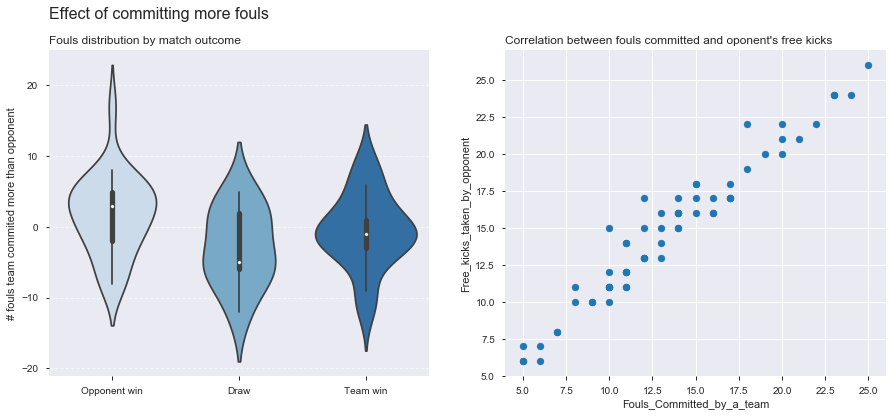

In [23]:
match_df['Fouls_difference'] = match_df['Fouls_Committed_Team'] - match_df['Fouls_Committed_Opponent']

# Exclude penalty shoot outs as they skew the data
keep = ['Pens' not in x for x in match_df['Result']]

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[15, 6])
sns.violinplot(x='Result', y='Fouls_difference', data=match_df[keep], ax=ax, palette='Blues')

for spine in ['top', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=.6)
ax.set_xlabel('')
ax.set_ylabel('# fouls team commited more than opponent')
ax.set_title('Fouls distribution by match outcome', ha='left', fontsize=12, x=0)

ax1.scatter(match_df['Fouls_Committed_Team'], match_df['Free_Kicks_Opponent'])
ax1.set_xlabel('Fouls_Committed_by_a_team')
ax1.set_ylabel('Free_kicks_taken_by_opponent')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Correlation between fouls committed and oponent\'s free kicks', 
             ha='left', fontsize=12, x=0)

plt.suptitle('Effect of committing more fouls', ha='left', x=.125, fontsize=16)
plt.show()

So apparently, fewer fouls commited = better chance of winning. 

Again we can't be sure if this is a correlation or a causation - losing teams are more likely to foul out of desparation, and in doing so concede set pieces. 

What we do know from the second plot, which in retrospect is no surprise at all, is that it definitely leads to the opposition haveing more free kicks. Tricky to pin down.

---
Lets also look at which teams are the dirtiest / cleanest:

## Be precise
It makes sense that precise, skilled football would be reflected in high passing and shot accuracy. I will therefore plot this information against the points acquired metric used previously for the maps.

The below scatter plot represents this information, with the size of each marker related to the points that team acquired

In [24]:
fifa_data['Shot_Accuracy_%'] = 100 * fifa_data['On-Target'] / (fifa_data['On-Target'] + fifa_data['Off-Target'])
team_precision = fifa_data.groupby('Team')['Pass_Accuracy_%', 'Shot_Accuracy_%'].mean().reset_index()
team_precision = \
    team_precision.merge(country_performance[['Team_Team', 'Total_Points']], left_on='Team', right_on='Team_Team')

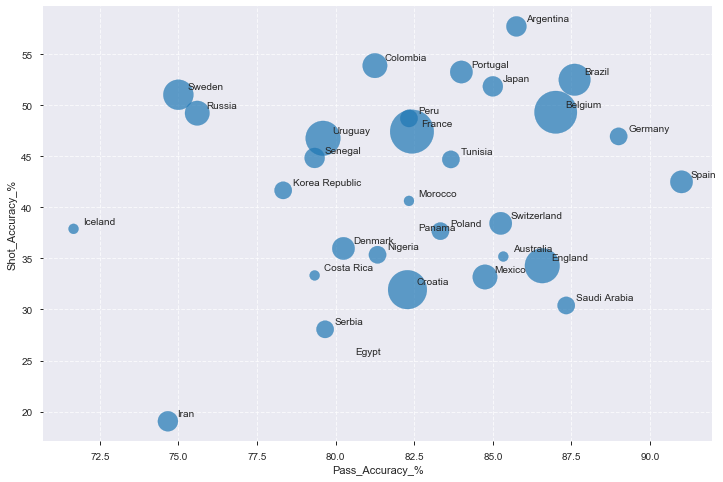

In [25]:
fig, ax = plt.subplots(1, 1, figsize = [12, 8])
ax.scatter(team_precision['Pass_Accuracy_%'], team_precision['Shot_Accuracy_%'],
           s=100 * team_precision['Total_Points'], alpha=.7)
ax.set_xlabel('Pass_Accuracy_%')
ax.set_ylabel('Shot_Accuracy_%')

for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)

ax.grid(linestyle='--', alpha=.7)

for i, row in team_precision.iterrows():
    ax.annotate(row['Team'], xy=(row['Pass_Accuracy_%']+.3, row['Shot_Accuracy_%']+.5))
plt.show()

This is another relationship that is difficult to pin down. 
If does seem that shot and pass accuracy are correlated, but it is not as clear whether they both increase performance (marker size).

It appears that pass accuracy has a larger effect than shot accuracy if anything.

Spain killing it on the pass accuracy as per usual, whilst Iran taking pot shots apparently.

# 4. Explore relationships with MotM

This dataset is to Predict FIFA 2018 Man of the Match, so makes sense to follow that as an objective despite this data set providing the opportunity to predict a few things.

A good first step before any predictions is to visualise the relationship between whether a team contained the man of the match (MotM) and some of the other variables in the data set. 

To do this though, I'll need to make the man of the match variables numeric first.

In [26]:
for var in ['Man_of_the_Match_Opponent', 'Man_of_the_Match_Team']:
    match_df.loc[match_df[var] == 'Yes', var] = 1
    match_df.loc[match_df[var] == 'No', var] = 0

### 4.1 Team goals scored vs. MotM

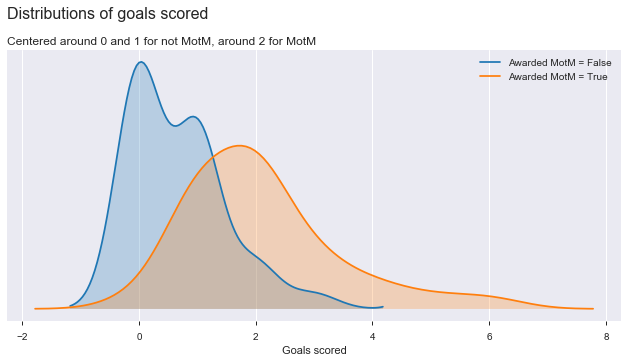

In [27]:
fig, ax = plt.subplots(1, 1, figsize=[11, 5])

for mom in match_df['Man_of_the_Match_Team'].unique():
    sns.kdeplot(match_df.loc[match_df['Man_of_the_Match_Team'] == mom, 'Goal_Scored_Team'], 
                ax=ax, label='Awarded MotM = {}'.format(bool(mom)), shade=True)

ax.set_xlabel('Goals scored')
    
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.yaxis.set_visible(False)

ax.legend(frameon=False)
plt.suptitle('Distributions of goals scored', ha='left', fontsize=16, x=.125, y=1)
plt.title('Centered around 0 and 1 for not MotM, around 2 for MotM', ha='left', x=0)
plt.autoscale()
plt.show()

- Predictably, the more goals a team scores the more likely the MotM is to be on their team.

### 4.2 Team possession vs. MotM

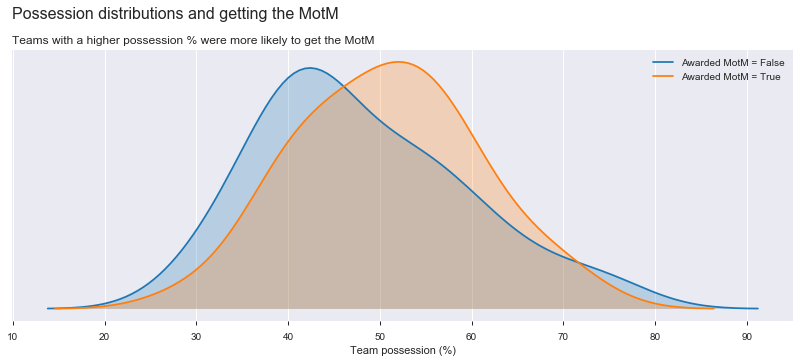

In [28]:
fig, ax = plt.subplots(1, 1, figsize=[14, 5])

for mom in match_df['Man_of_the_Match_Team'].unique():
    sns.kdeplot(match_df.loc[match_df['Man_of_the_Match_Team'] == mom, 'Ball_Possession_%_Team'], 
                ax=ax, label='Awarded MotM = {}'.format(bool(mom)), shade=True)
ax.set_title('Teams with a higher possession % were more likely to get the MotM', ha='left', fontsize=12, x=0, y=1)

ax.set_xlabel('Team possession (%)')    
for spine in ['top', 'left', 'right', 'bottom']:
    ax.spines[spine].set_visible(False)
ax.yaxis.set_visible(False)
ax.legend(frameon=False)

plt.suptitle('Possession distributions and getting the MotM', ha='left', x=.125, fontsize=16, y=1)
plt.autoscale()
plt.show()

- Higher team possessions lead to a reasonably higher chance of getting MotM, but not hugely so.

### 4.3 Match outcome vs. MotM

From intuition, and also the above distribution comparisons, we would expect the MotM to be on the winning team more often than not.

I also want to break this down by the group stage vs. the knockouts, so will create a simpler Round column.

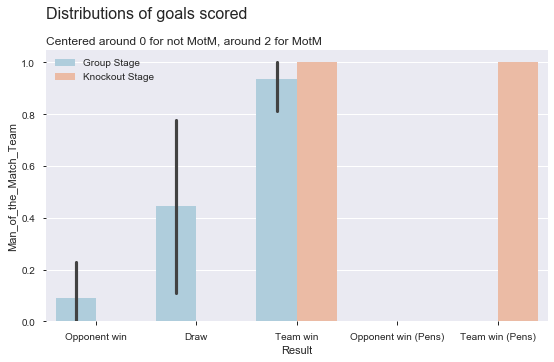

In [29]:
match_df['Simple Round'] = match_df['Round_Team']
match_df.loc[match_df['Round_Team'] != 'Group Stage', 'Simple Round'] = 'Knockout Stage'

fig, ax = plt.subplots(1, 1, figsize=[9, 5])
sns.barplot(x='Result', y='Man_of_the_Match_Team', hue='Simple Round', data=match_df, palette=sns.color_palette("RdBu_r", 2))
ax.legend(frameon=False)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
plt.suptitle('Distributions of goals scored', ha='left', fontsize=16, x=.125, y=1)
plt.title('Centered around 0 for not MotM, around 2 for MotM', ha='left', x=0)
plt.show()

- In the group stages, the MotM is virtually always on the winning team with a few rare occurences on the drawing and losing sides.

- In the knockout stages, the MotM is exclusively on the winning side.

---
Out of interest, the MotM awards to losing teams were:

In [30]:
losing_matches = match_df[(match_df['Man_of_the_Match_Team'] == 1) &
                          (~match_df['Result'].isin(['Team win', 'Team win (Pens)']))]

In [31]:
losing_matches[['Date', 'Team_Team', 'Opponent_Team', 'Goal_Scored_Team', 'Result', 'Man_of_the_Match_Team']]

,Date,Team_Team,Opponent_Team,Goal_Scored_Team,Result,Man_of_the_Match_Team
18,17-06-2018,Germany,Mexico,0,Opponent win,1
20,17-06-2018,Brazil,Switzerland,1,Draw,1
40,21-06-2018,Denmark,Australia,1,Draw,1
68,25-06-2018,Spain,Morocco,2,Draw,1
78,26-06-2018,Iceland,Croatia,1,Opponent win,1
86,27-06-2018,Switzerland,Costa Rica,2,Draw,1


## 5. Predicting Man of the Match

### Approach 1 
- It makes sense to use the original dataset for the prediction section, despite it containing essentially duplicate/mirrored records, just so it can be compared to any other kernels doing a prediction.
- Drop columns that intuitively don't have predictive power (such as 'Date')
- Clean up missing values in own goals (0 will replace NaN since that means no own goals were scored) and dummy encode our two categorical variables

In [32]:
f_df = fifa_data.copy()

In [33]:
f_df.isna().sum()

Date                        0
Team                        0
Opponent                    0
Goal_Scored                 0
Ball_Possession_%           0
Attempts                    0
On-Target                   0
Off-Target                  0
Blocked                     0
Corners                     0
Offsides                    0
Free_Kicks                  0
Saves                       0
Pass_Accuracy_%             0
Passes                      0
Distance_Covered_(Kms)      0
Fouls_Committed             0
Yellow_Card                 0
Yellow_&_Red                0
Red                         0
Man_of_the_Match            0
1st_Goal                   34
Round                       0
PSO                         0
Goals_in_PSO                0
Own_goals                 116
Own_goal_Time             116
Team Continent              0
Shot_Accuracy_%             0
dtype: int64

In [34]:
f_df = f_df.drop(['Date','Team', 'Opponent', 'Round', 'Team Continent'], axis = 1)

In [35]:
f_df['Own_goals'] = f_df['Own_goals'].fillna(0).astype(int)
f_df['Own_goal_Time'] = f_df['Own_goal_Time'].fillna(0).astype(int)
f_df['1st_Goal'] = f_df['1st_Goal'].fillna(0).astype(int)

dummy encode our two categorical variables

In [36]:
f_df['PSO'] = pd.get_dummies(f_df.PSO).Yes
f_df['Man_of_the_Match'] = pd.get_dummies(f_df['Man_of_the_Match']).Yes

Create a column to indicate who won the match. 
By groups of two rows, decide who got the maximum score within a game and assign 1 for winners and 0 for losers

In [37]:
game_group = [n for n in range(len(f_df)//2)]
game_group = np.repeat(game_group, 2)

f_df['winner'] = f_df.groupby(game_group)['Goal_Scored'].transform(lambda x: x == max(x))
f_df['winner'] = f_df['winner'].map({True: 1, False: 0})

Separate Target and Explanatory Variable

In [38]:
x = f_df.drop('Man_of_the_Match', axis = 1)
y = f_df['Man_of_the_Match']

What kind of relationships exist within the data? Looking at distributions for each continuous variable, separated by winners and losers of Man of the Match

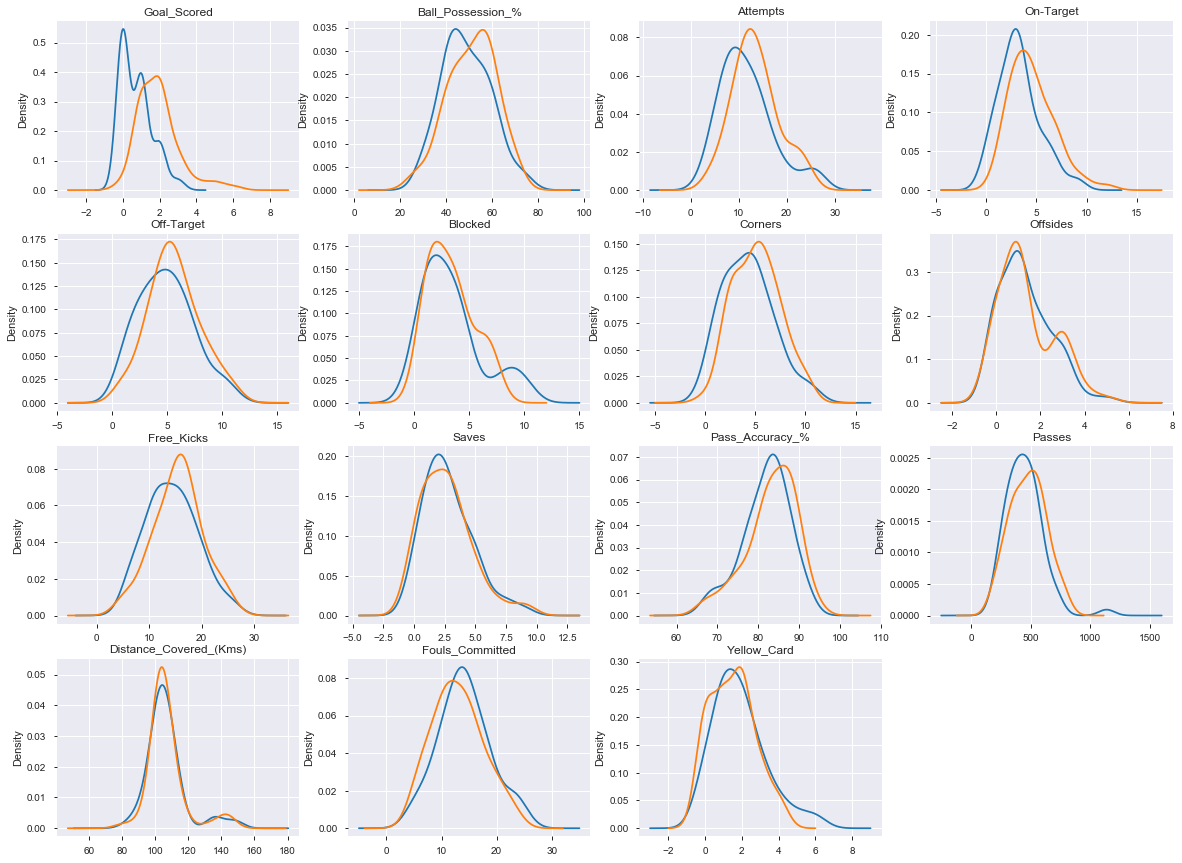

In [39]:
f = plt.figure(figsize = (20, 15))

## Add a density plot for each of the continuous predictors
for i in range(0, 15):
    f.add_subplot(4, 4, i + 1)
    f_df.iloc[:, i].groupby(y).plot(kind = 'kde', title = f_df.columns[i])

- The distribution 'Goal Scored' and 'Ball Possession %' differ based on which team won Man of the Match. We now scale our data to feed it into classification models, expecting to see these variable relationships come into play

In [40]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x)

Split data into 1/3rd and 2/3rd

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y,random_state = 42,test_size = .33,stratify = y)

__Logistic Regression__ and Evaluate Performance

In [42]:
log_reg = LogisticRegression()
log_reg.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
preds = log_reg.predict(xtest)
print(confusion_matrix(preds, ytest))
print('Test accuracy: ', accuracy_score(preds, ytest))

[[17  3]
 [ 5 18]]
Test accuracy:  0.813953488372093


__KNN__ using values of K from 1 to the number of training rows

In [44]:
errors_knn = pd.DataFrame(columns = ['k_value', 'train_acc', 'test_acc'])

for n in range(1, len(xtrain)):
    knn_clf = knn(n_neighbors = n)
    knn_clf.fit(X = xtrain, y = ytrain)
    
    preds = knn_clf.predict(xtrain)
    errors_knn.loc[n, 'train_acc'] = accuracy_score(preds, ytrain)
    
    preds = knn_clf.predict(xtest)
    errors_knn.loc[n, 'test_acc'] = accuracy_score(preds, ytest)

<Figure size 1440x864 with 0 Axes>

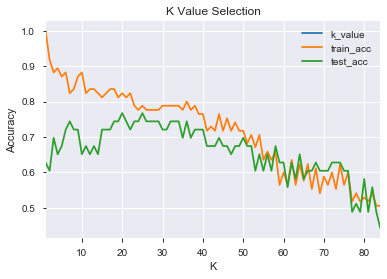

In [45]:
f = plt.figure(figsize = (20, 12))
errors_knn.plot(title = 'K Value Selection')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [46]:
preds = knn_clf.predict(xtest)
print(confusion_matrix(preds, ytest))
print('Test accuracy: ', errors_knn.test_acc.max())

[[ 5  7]
 [17 14]]
Test accuracy:  0.7674418604651163


- With the optimal value of K, __KNN__ outperforms __Logistic Regression__ on the test set.

__Random Forest__ with different numbers of trees, depths and splitting criteria using gridsearch

In [47]:
rand_for = rf()

grid = {'n_estimators': [5, 10, 15, 20, 30, 50, 100, 200, 500],
        'max_depth' : [None, 2, 3, 5, 10, 20],
        'criterion': ['gini', 'entropy'],
        'random_state' : [69]}

grid_rand = gs(rand_for, grid, cv = 10)

grid_rand.fit(xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [48]:
print('Best mean CV accuracy: ', grid_rand.best_score_)
print('Holdout test set accuracy: ', accuracy_score(grid_rand.best_estimator_.predict(xtest), ytest))
print('Best parameters: ', grid_rand.best_params_)

Best mean CV accuracy:  0.8823529411764706
Holdout test set accuracy:  0.7906976744186046
Best parameters:  {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100, 'random_state': 69}


#### Observation over Test Accuracy: 
- Logistics Regression - 0.814 (81.4%)
- KNN - 0.764 (76.4%)
- Random Forest - 0.791 (79.1%)

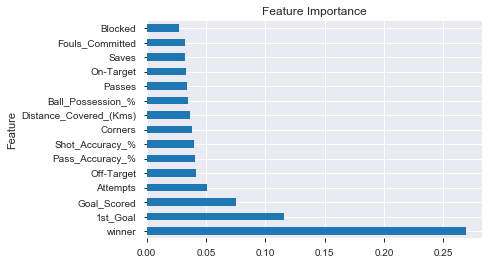

In [49]:
feat_imp_rf = pd.DataFrame({'Feature' : f_df.drop('Man_of_the_Match', axis = 1).columns,
                            'Importance' : grid_rand.best_estimator_.feature_importances_})

feat_imp_rf.set_index('Feature', inplace = True)
feat_imp_rf.sort_values('Importance', inplace = True)

feat_imp_rf.nlargest(15,'Importance').plot(kind = 'barh', legend = None, title = 'Feature Importance')
plt.show()

### Approach 2 

Use Match_df - Optimised Version made during above EDA 

- __Future work__ - __PCA__ over the features will be helpful for this analysis

In [50]:
df = match_df.copy()

In [51]:
df = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [52]:
df = df.drop(['Date','Simple Round'], axis = 1)

In [53]:
# Specify the label (just in case we want to predict something else)
label_name = 'Man_of_the_Match_Team'

# Categorical features are the non numeric ones
categoricals = df.columns[df.dtypes == 'object'].tolist()

# Label encode them otherwise can't use them
for cat_feat in categoricals:
    encoder = LabelEncoder()
    df[cat_feat] = encoder.fit_transform(df[cat_feat])
label = df.pop(label_name)

# Don't specify the label as a categorical
if label_name in categoricals:
    categoricals.remove(label_name)

In [55]:
x = df.drop(['Man_of_the_Match_Opponent'], axis = 1)

y = match_df['Man_of_the_Match_Team']

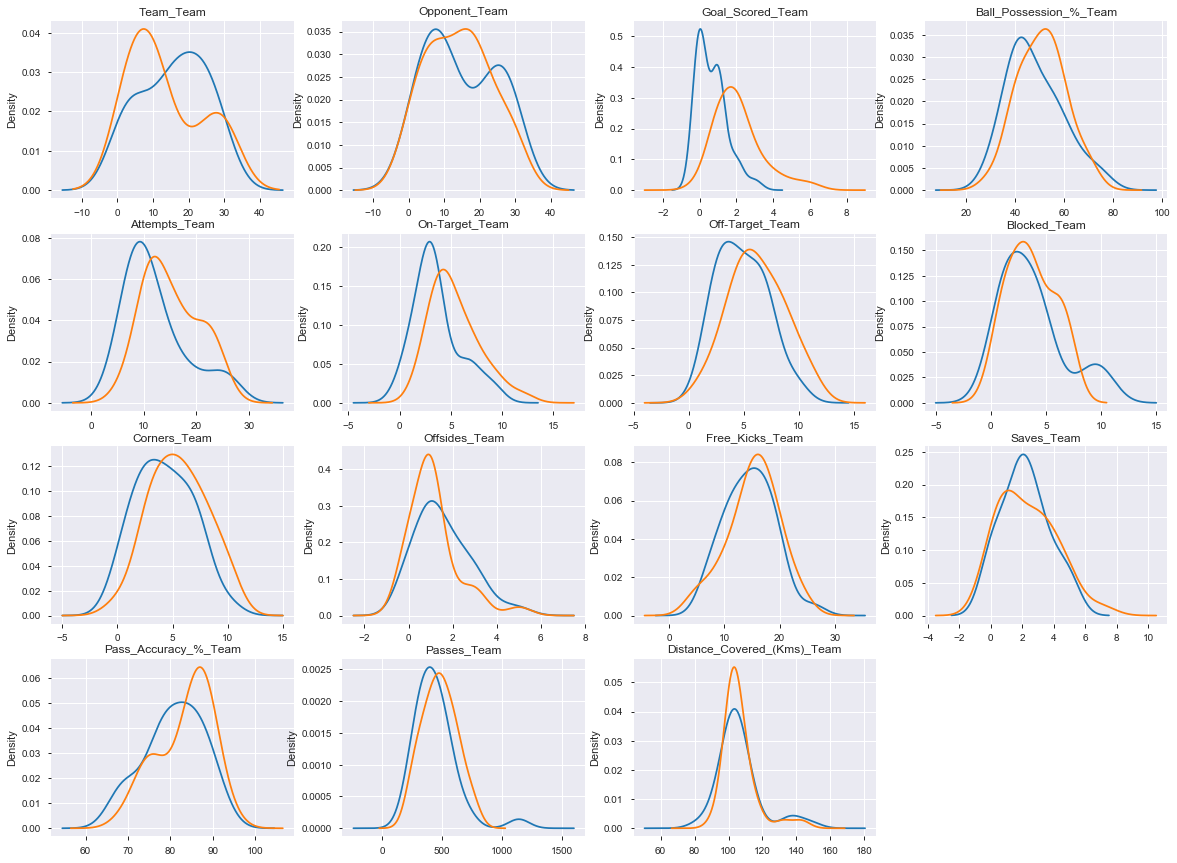

In [56]:
f = plt.figure(figsize = (20, 15))

## Add a density plot for each of the continuous predictors
for i in range(0, 15):
    f.add_subplot(4, 4, i + 1)
    df.iloc[:, i].groupby(y).plot(kind = 'kde', title = df.columns[i])

In [57]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x)

In [58]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                random_state = 42, 
                                                test_size = .33,
                                                stratify = y)

In [59]:
log_reg = LogisticRegression()
log_reg.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
preds = log_reg.predict(xtest)
print(confusion_matrix(preds, ytest))
print('Test accuracy: ', accuracy_score(preds, ytest))

[[10  2]
 [ 1  8]]
Test accuracy:  0.8571428571428571


In [61]:
# KNN
errors_knn = pd.DataFrame(columns = ['k_value', 'train_acc', 'test_acc'])

for n in range(1, len(xtrain)):
    knn_clf = knn(n_neighbors = n)
    knn_clf.fit(X = xtrain, y = ytrain)
    
    preds = knn_clf.predict(xtrain)
    errors_knn.loc[n, 'train_acc'] = accuracy_score(preds, ytrain)
    
    preds = knn_clf.predict(xtest)
    errors_knn.loc[n, 'test_acc'] = accuracy_score(preds, ytest)

<Figure size 1440x864 with 0 Axes>

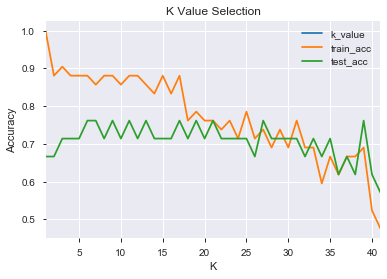

In [62]:
f = plt.figure(figsize = (20, 12))
errors_knn.plot(title = 'K Value Selection')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [63]:
preds = knn_clf.predict(xtest)
print(confusion_matrix(preds, ytest))
print('Test accuracy: ', errors_knn.test_acc.max())

[[ 2  0]
 [ 9 10]]
Test accuracy:  0.7619047619047619


In [64]:
#RF
rand_for = rf()

grid = {'n_estimators': [5, 10, 15, 20, 30, 50, 100, 200, 500],
        'max_depth' : [None, 2, 3, 5, 10, 20],
        'criterion': ['gini', 'entropy'],
        'random_state' : [69]}

grid_rand = gs(rand_for, grid, cv = 10)

grid_rand.fit(xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [65]:
print('Best mean CV accuracy: ', grid_rand.best_score_)
print('Holdout test set accuracy: ', accuracy_score(grid_rand.best_estimator_.predict(xtest), ytest))
print('Best parameters: ', grid_rand.best_params_)

Best mean CV accuracy:  0.8571428571428571
Holdout test set accuracy:  0.9047619047619048
Best parameters:  {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 20, 'random_state': 69}


#### Observation over Test Accuracy: 
- Logistics Regression - 0.857 (85.7%)
- KNN - 0.762 (76.2%)
- Random Forest - 0.905 (90.5%)

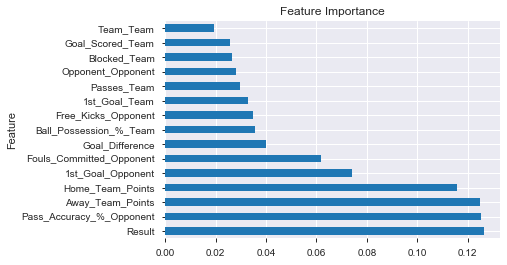

In [66]:
feat_imp_rf = pd.DataFrame({'Feature' : df.drop('Man_of_the_Match_Opponent', axis = 1).columns,
                            'Importance' : grid_rand.best_estimator_.feature_importances_})

feat_imp_rf.set_index('Feature', inplace = True)
feat_imp_rf.sort_values('Importance', inplace = True)

feat_imp_rf.nlargest(15,'Importance').plot(kind = 'barh', legend = None, title = 'Feature Importance')

- Save the model

In [67]:
joblib.dump(grid_rand, 'fifa_rf.pkl')

['fifa_rf.pkl']

### Approah 3: Using Light GBM

In [68]:
# Specify the label (just in case we want to predict something else)
label_name = 'Man_of_the_Match'

# Categorical features are the non numeric ones
categoricals = fifa_data.columns[fifa_data.dtypes == 'object'].tolist()

# Label encode them otherwise LightGBM can't use them
for cat_feat in categoricals:
    encoder = LabelEncoder()
    fifa_data[cat_feat] = encoder.fit_transform(fifa_data[cat_feat])
label = fifa_data.pop(label_name)

# Don't specify the label as a categorical
if label_name in categoricals:
    categoricals.remove(label_name)

In [69]:
# boosting_type=gbdt, rf, dart, goss,etc can be used to build models

clf = lgbm.LGBMClassifier(
        boosting_type='rf',
        verbose=-1,
        bagging_freq = 1,
        bagging_fraction=0.5,
        feature_fraction=0.5
    )
y_prob = cross_val_predict(
    estimator=clf, 
    cv=5, 
    X=fifa_data, 
    y=label,
    fit_params={'categorical_feature': categoricals},
    method='predict_proba'
)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true=label, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66        64
           1       0.66      0.66      0.66        64

    accuracy                           0.66       128
   macro avg       0.66      0.66      0.66       128
weighted avg       0.66      0.66      0.66       128



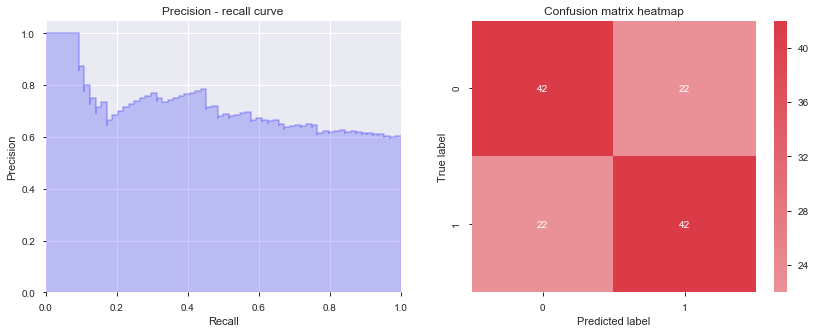

In [70]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])

# Precision recall curve
precision, recall, _ = precision_recall_curve(label, y_prob[:, 1])
ax.step(recall, precision, color='b', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Precision - recall curve')

# Confusion matrix
cnf_matrix = confusion_matrix(label, y_pred)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
heatmap = sns.heatmap(cnf_matrix, annot=True, fmt='d', ax=ax1, cmap=cmap, center=0)
ax1.set_title('Confusion matrix heatmap')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')

plt.show()

So the performance is OK, but to be honest not quite as accurate as I expected. I suspect this is due to not knowing the outcome of the match, so the predictor doesn't have access to the really discrimatory feature.

### Feature importance
It's always interesting to see which of our inputs are the strongest predictor, so lets visualise this too. To return a classifier object with importances attached, use the same model object assessed in CV and train on the full dataset.

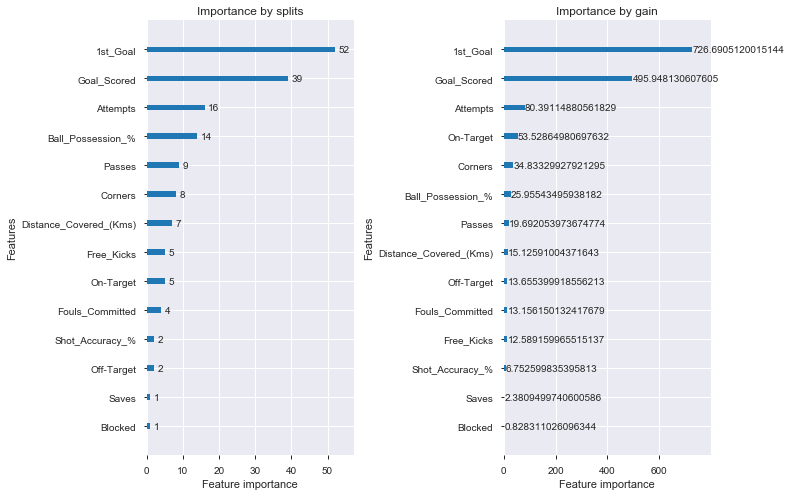

In [71]:
clf.fit(fifa_data, label, categorical_feature=categoricals)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[11, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()